In [128]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [129]:
def show_img(img, gray=False, splt=111, title="Image",axis="off", in_cv2=False):
    if in_cv2:
        show_cv2_img(img)
        return
    
    if type(splt) == int:
        plt.subplot(splt)
    else:
        plt.subplot(*splt)
    
#     plt.subplot(splt)
    plt.axis(axis)
    plt.title(title)
    if gray:
        plt.imshow(img, "gray")
    else:
        plt.imshow(img)

In [190]:
def show_imgs(*args,grid=None,gray=False, titles=None):
    grid = grid or (len(args), 1)
    
    if len(args) == 2:
        plt.subplots_adjust(top=2, right=2)
        grid = (1,2)
    else:
        plt.subplots_adjust(top=grid[0], right=grid[1])
    print(grid)
    if not titles:
        titles = ["image" * len(args)] 
    for i, (img, title) in enumerate(zip(args, titles)):
        splt= grid+(i+1,)
        print(splt)
        show_img(args[i], gray=gray, splt=splt, title=title)

In [131]:
def show_cv2_img(img):
    cv2.imshow('sdf', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [192]:
def resize_image(img, limit_w = 500, limit_h = 500):
    h = img.shape[0]
    w = img.shape[1]
    ratio = 1
    if w>h:
        if w > limit_w:
            ratio = limit_w / w
    else:
        if h> limit_h:
            ratio = limit_h / h
    print(ratio)
    return cv2.resize(img, None, fx=ratio, fy=ratio)

In [145]:
def noisy(image):
    row,col= image.shape
    mean = 0
    var = 10
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return noisy

1
(225, 226, 3)


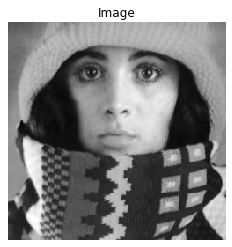

In [225]:
img_bgr = cv2.imread('../images/girl2.png')
img_bgr = resize_image(img_bgr)
print(img_bgr.shape)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_rgb = np.copy(img_bgr[:,:,::-1])
show_img(img_rgb)

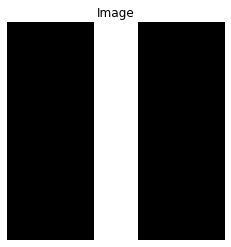

In [248]:
img_rgb = np.zeros((100, 100,3), dtype=np.uint8)
img_rgb[:, 40:60] = 255
show_img(img_rgb)

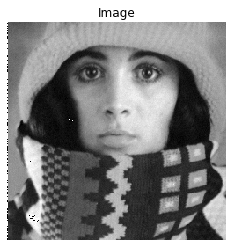

In [247]:
img_noise = noisy(img_gray)
show_img(img_noise.astype(np.uint8),gray=True)

In [234]:
def gaussian(x,y,sigma):
    return np.exp(-np.power(x-y,2)/(2*sigma**2))

def weight(img,d,sigma=0.2):
#     print(img)
    dis = np.zeros(img.shape)
#     w = np.zeros(img.shape)
    nx, ny = (1, 1)
    x = np.linspace(1, d, d)
    y = np.linspace(1, d, d)
    xv, yv = np.meshgrid(x, y)
    x = np.abs(xv - np.ceil(d/2))
    m = x + x.T
    dis[m%2==1] = 1
    ind = np.ceil((d-1)/2).astype(np.int)
    dis[ind,:] = 0 
    dis[:,ind] = 1 

    
    dif = (img - img[ind, ind])**2

    R = np.exp( -dif / (2*sigma**2))
    w = R.copy()
    # adjacent pixels
    w[ind,ind+1] *= w[ind, ind+1]
    w[ind+1,ind] *= w[ind+1, ind]
    w[ind-1,ind] *= w[ind-1, ind]
    w[ind,ind-1] *= w[ind, ind-1]
    
    #pixels in same row
    t = w[ind,ind+1]
    for i in range(ind+2,d):
        w[ind,i] *= w[ind,i-1]*t
        
    t = w[ind,ind-1]
    for i in range(0,ind-1):
        w[ind,i] *= w[ind,ind-1]*t
    
    #pixels in same column
    t = w[ind+1,ind]
    for i in range(ind+2,d):
        w[i,ind] *= w[ind+1,ind]*t
        
    t = w[ind-1,ind]
    for i in range(0,ind-1):
        w[i,ind] *= w[ind-1,ind]*t
        
    ts_v = np.exp((-np.diff(img, axis=0)**2) / (2 * sigma**2))
    ts_h = np.exp((-np.diff(img, axis=1)**2) / (2 *sigma**2))
    


    # Q1    
    
    for i in range(ind-1,-1,-1):
        for j in range(ind+1,d):
            if dis[i,j]==1:
                w[i,j] *= w[i+1,j]*ts_v[i,j]
            else:
                w[i,j] *= w[i,j-1]*ts_h[i,j-1]
   
    # Q2
    
    for i in range(ind-1,-1,-1):
        for j in range(ind-1,-1,-1):
            if dis[i,j]==1:
                w[i,j] *= w[i+1,j]* ts_v[i,j]
            else:
                w[i,j] *= w[i,j+1] *ts_h[i,j]
    # Q3
    for i in range(ind+1,d):
        for j in range(ind-1,-1,-1):
            if dis[i,j]==1:
                w[i,j] *= w[i-1,j]* ts_v[i-1,j]
            else:
                w[i,j] *= w[i,j+1]* ts_h[i,j]

    # Q4
    for i in range(ind+1,d):
        for j in range(ind+1,d):
            if dis[i,j]==1:
                w[i,j] *= w[i-1,j]*ts_v[i-1,j]
            else:
                w[i,j] *= w[i,j-1]*ts_h[i,j-1]
    return w
def propogative_filtering(img,d=5):
    try:
        h,w,c = img.shape[:]
    except:
        h,w = img.shape[:]
        c =1
    pad_img = np.pad(img,((d,d), (d,d), (0,0)),'edge').astype(np.float64)
#     plt.imshow(pad_img.astype(np.uint8))
    out = np.zeros(img.shape)
    print(c)
    for i in range(d,h+d):
        print(i,end=" ")
        for j in range(d,w+d):
            for k in range(c):
                wei = weight(pad_img[i-d:i+d+1,j-d:j+d+1, k],d*2+1,50)
                out[i-d,j-d, k] = np.sum(np.multiply(wei,pad_img[i-d:i+d+1,j-d:j+d+1, k]))/np.sum(wei)
    return out.astype(np.uint32)

In [235]:
def bilateral_filter(img, sig_c=40, sig_s=30):
    out = cv2.bilateralFilter(img, -1, sig_c, sig_s)
    return out
    

In [249]:
print(img_rgb.shape)
start = time()
out = propogative_filtering(img_rgb,d=5)
end = time()
print('\n', end - start, " seconds")

(100, 100, 3)
3
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 
 10.864951610565186  seconds


In [250]:
out.shape
# cv2.imwrite("out_clr.jpg",out.astype(np.uint8))

(100, 100, 3)

In [251]:
img_blf = bilateral_filter(img_rgb)

(1, 3)
(1, 3, 1)
(1, 3, 2)
(1, 3, 3)


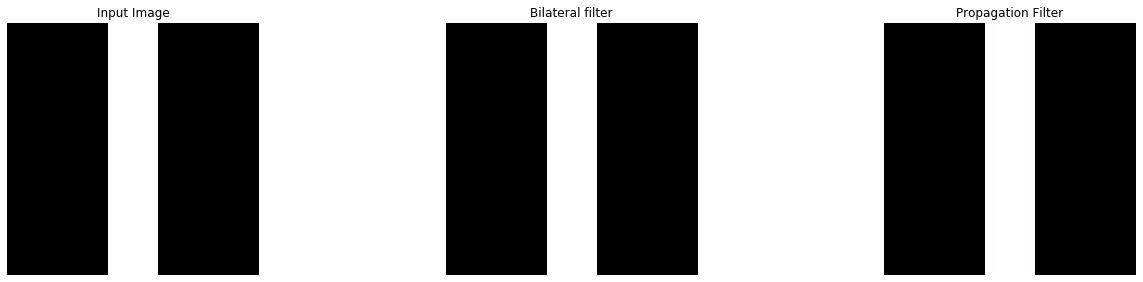

In [252]:
show_imgs(img_rgb, img_blf, out, grid=(1,3), gray=False, titles=["Input Image", "Bilateral filter", "Propagation Filter"])

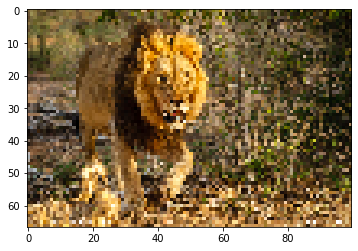

In [188]:
plt.imshow(out)

(1, 3)
(1, 3, 1)
(1, 3, 2)
(1, 3, 3)


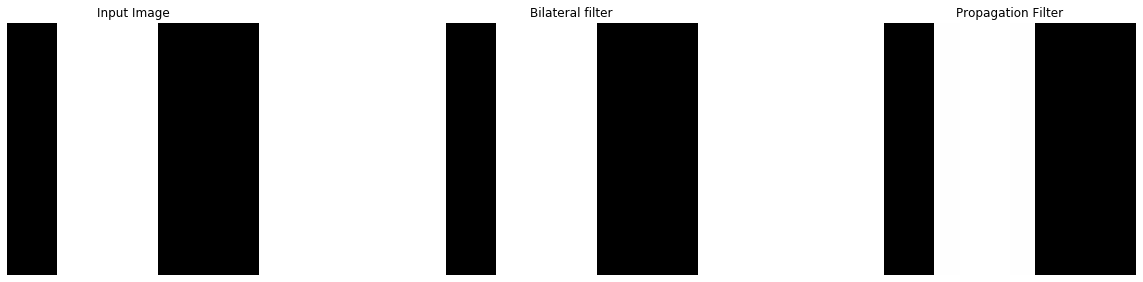

In [253]:
x = 30
y = 30
show_imgs(img_rgb[x:x+50, y:y+50], img_blf[x:x+50, y:y+50], out[x:x+50, y:y+50], grid=(1,3), gray=False, titles=["Input Image", "Bilateral filter", "Propagation Filter"])



In [243]:
0.12*255


30.599999999999998